<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Natural Process Language
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [27]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize 

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [5]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: c:\Users\fSIoF\Documents\IA\NLP\clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 18.3MB/s]


In [6]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [7]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


## Exploratory Data Analysis

In [ ]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

In [10]:
df_reviews.dtypes

Review Text    object
Rating          int64
dtype: object

In [26]:
df_reviews.value_counts()

Review Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Rating
Perfect fit and i've gotten so many compliments. i buy all my suits from here now!                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
df_reviews.isnull().sum()

In [11]:
# Based on subject Data Analysis from University of Buenos Aires
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

#### Data distribution respect to the ratings

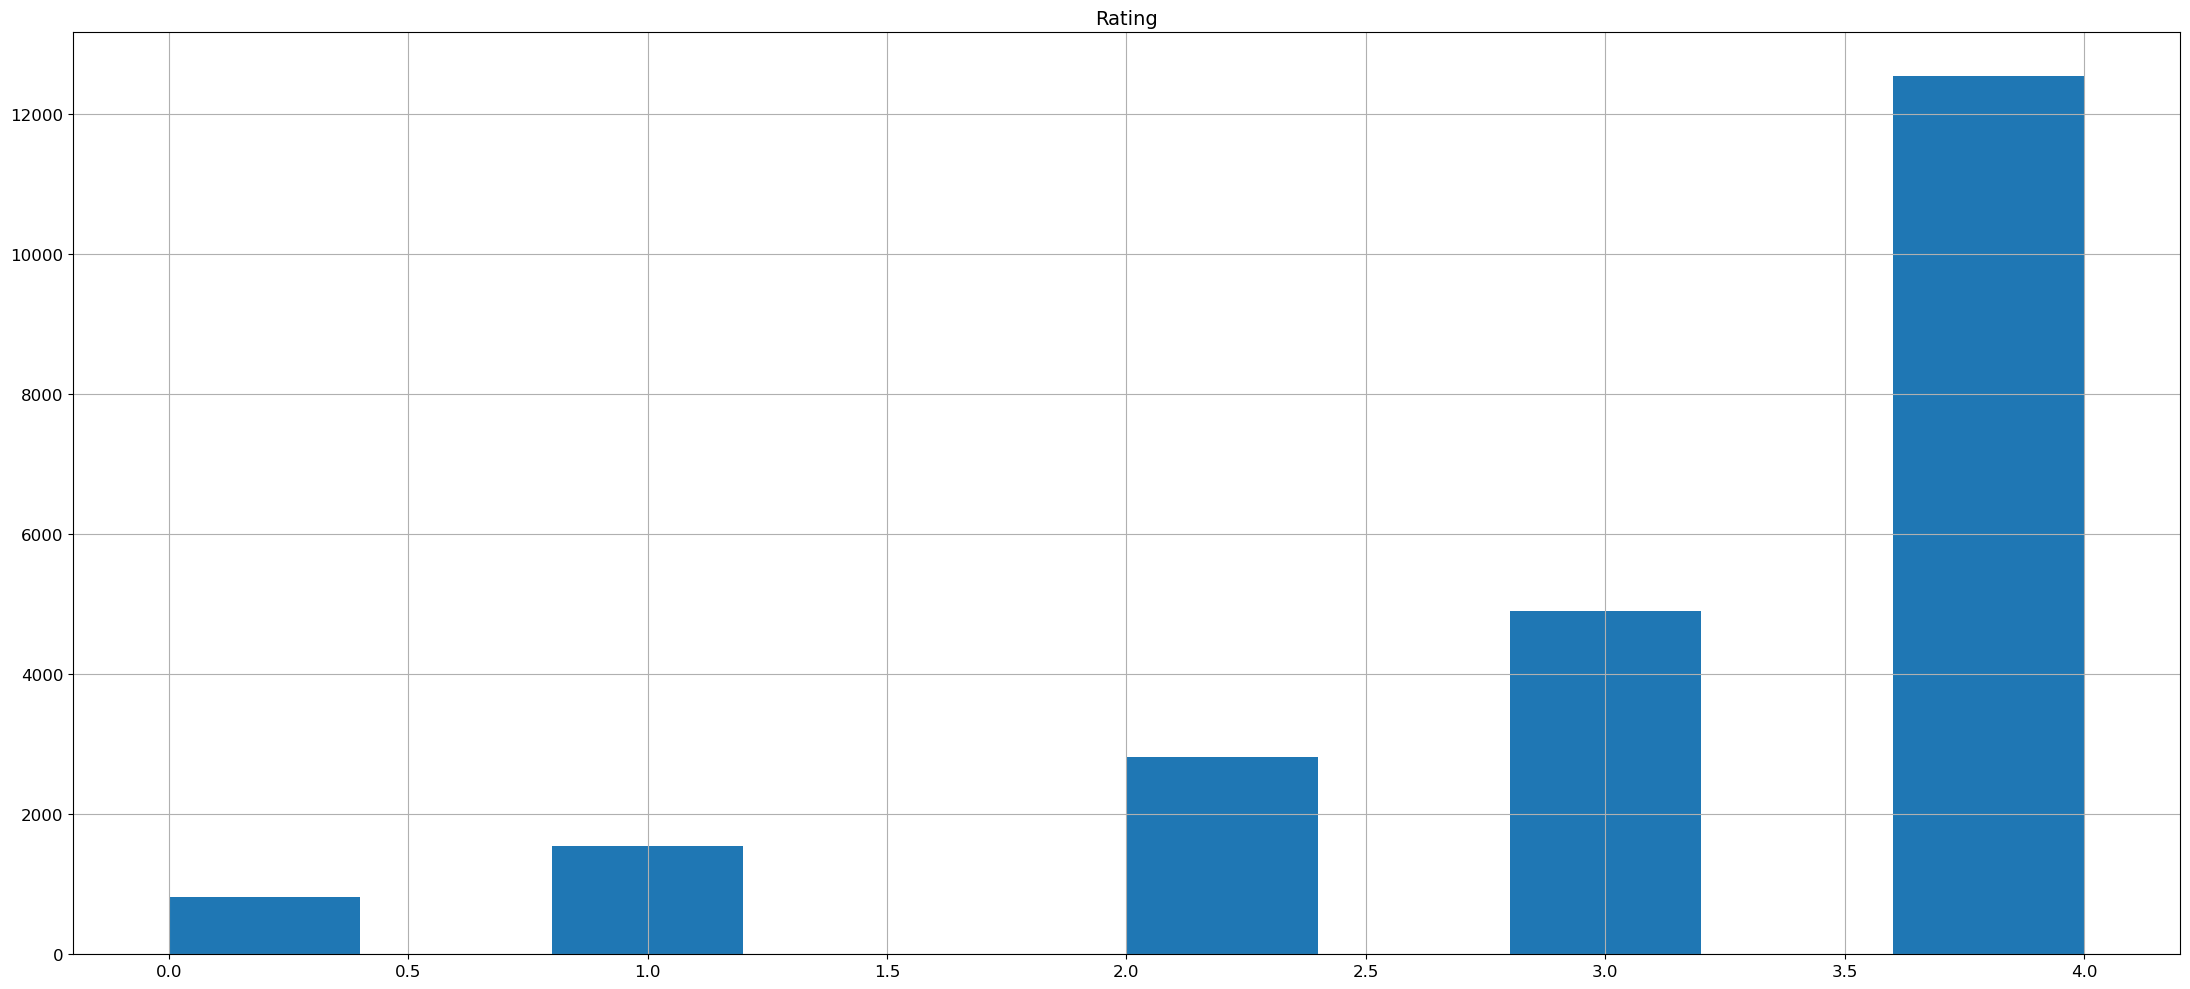

In [12]:
display_dataset_distributions(df_reviews)

In [15]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
df_reviews['Review Text']

0        Absolutely wonderful - silky and sexy and comf...
1        Love this dress!  it's sooo pretty.  i happene...
2        I had such high hopes for this dress and reall...
3        I love, love, love this jumpsuit. it's fun, fl...
4        This shirt is very flattering to all due to th...
                               ...                        
23481    I was very happy to snag this dress at such a ...
23482    It reminds me of maternity clothes. soft, stre...
23483    This fit well, but the top was very see throug...
23484    I bought this dress for a wedding i have this ...
23485    This dress in a lovely platinum is feminine an...
Name: Review Text, Length: 22641, dtype: object

In [17]:
ds_reviews = df_reviews['Review Text'].to_numpy()
ds_reviews

array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       ...,
       "This fit well, but the top was very see through. this never would have worked for me. i

In [ ]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
num_rows = ds_reviews.shape
print(f'The number of rows of the vector is: ', num_rows)

In [ ]:
# Alumno: Concatenar todas las reviews para armar el corpus

In [ ]:
# Alumno: ¿Cuál es la longitud de ese corpus?

In [ ]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

In [ ]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

In [ ]:
# Alumno: ¿Cuántos tokens/palabras hay?

In [ ]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

In [ ]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

In [ ]:
# Alumno: Convertir las palabras/tokens a números

In [ ]:
# Alumno: Determinar cual es la oración más larga

In [ ]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

In [ ]:
# Alumno: Observar las dimensiones de la variable input

In [ ]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

In [ ]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

In [ ]:
# Alumno: determinar la dimensiones de entrada y salida

### 2 - Entrenar el modelo con Embeddings + LSTM

In [ ]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout